In [1]:
# Yomitoku Clientの使用例
# このノートブックでは、Yomitoku Clientを使用してSageMaker Yomitokuの出力を
# 様々な形式（CSV、Markdown、HTML、JSON）に変|換する方法を示します

# 必要なライブラリのインポート
from yomitoku_client import YomitokuClient  # メインのクライアントクラス
from yomitoku_client.parsers.sagemaker_parser import SageMakerParser  # SageMakerの出力をパースするクラス
from yomitoku_client.samples import load_pdf_sample,load_image_sample # サンプルデータ（PDFと画像）
from pprint import pprint
import pandas as pd
import json

In [2]:
# ====================
# Parserの詳細説明
# ====================

# SageMakerParser とは？
# - AWS SageMaker の Yomitoku サービスから返される生のJSON出力を
#   Python の型安全な Pydantic モデルに変換するクラスです
# 
# 主な機能：
# 1. 生のJSONデータを構造化されたPythonオブジェクトに変換
# 2. データの検証とバリデーション
# 3. 型安全性の確保（IDEの補完機能が使える）
# 4. 各種フォーマットへの変換を容易にする

parser = SageMakerParser()

print("✅ SageMakerParser と YomitokuClient を初期化完了")

✅ SageMakerParser と YomitokuClient を初期化完了


In [3]:
#サンプル画像をダウンロード
import requests

def download_file(url, filename):
    response = requests.get(url, stream=True)
    if response.status_code == 200:
        with open(filename, 'wb') as f:
            for chunk in response.iter_content(1024):
                f.write(chunk)
        file_type = "Image" if filename.endswith(".png") else "PDF"
        print(f"{file_type} saved as {filename}")
    else:
        print(f"Failed to download file. Status code: {response.status_code}")

image_path = "../src/yomitoku_client/samples/image_sample.png"
pdf_path = "../src/yomitoku_client/samples/pdf_sample.pdf"
download_file(
    "https://mlism-marketplace-documents.s3.ap-northeast-1.amazonaws.com/samples/gallery1.jpg",
    image_path
)
download_file(
    "https://www.soumu.go.jp/main_content/000975178.pdf",
    pdf_path
)


# 画像サンプルデータを読み込み（これはYomitoku APIの出力形式のJSONデータ）
image_sample_data = load_image_sample()
# parse_dict: SageMaker Yomitokuの辞書形式の出力をPydanticモデルに変換
img_data = parser.parse_dict(image_sample_data)

pdf_sample_data = load_pdf_sample()
# PDFの場合も同様にSageMaker Yomitokuの出力をPydanticモデルに変換
pdf_data = parser.parse_dict(pdf_sample_data)


Image saved as ../src/yomitoku_client/samples/image_sample.png
PDF saved as ../src/yomitoku_client/samples/pdf_sample.pdf


## データエクスポート機能
### 様々な形式への変換とファイル保存

このセクションでは、OCR処理済みのデータを実用的な各種フォーマットに変換し、ファイルとして保存する方法を示します。

**対応フォーマット：**
- **CSV**: Excel等の表計算ソフトで開ける形式。データ分析に最適
- **Markdown**: GitHubやドキュメント作成に便利な軽量マークアップ形式
- **HTML**: ブラウザで直接表示可能。レポートやプレゼンテーションに活用
- **JSON**: プログラムで処理しやすい構造化データ。API連携やデータベース保存に最適

すべてのエクスポートファイルは `exported_data/` ディレクトリに整理して保存されます。

In [4]:
# エクスポート用のディレクトリを作成
import os
export_dir = "exported_data"
if not os.path.exists(export_dir):
    os.makedirs(export_dir)
    print(f"📁 エクスポートディレクトリを作成: {export_dir}/")
else:
    print(f"📁 既存のエクスポートディレクトリを使用: {export_dir}/")

📁 エクスポートディレクトリを作成: exported_data/


### CSV 形式

In [5]:
# 画像の識別結果（画像の場合は１枚のドキュメント）をCSVで保存
csv_image_path = os.path.join(export_dir, "image_recognitized_data.csv")
result =img_data.to_csv(output_path=csv_image_path,page_index=0)
print(f"✓ image_recognitized_data.csv ({os.path.getsize(csv_image_path):,} bytes)")

✓ image_recognitized_data.csv (7,986 bytes)


In [6]:
# PDFデータをCSVで保存
csv_pdf_path = os.path.join(export_dir, "pdf_recognitized_data_csv_folder")
# 複数ページの場合, pagesを指定しなくても良い、フォルダに保存される
pdf_data.to_csv_folder(folder_path=csv_pdf_path)
print(f"✓ pdf_recognitized_data_csv_folder ({os.path.getsize(csv_pdf_path):,} bytes)")
# また、その中の１つを指定して保存することもできる
csv_page1_path = os.path.join(export_dir, "pdf_recognitized_data_csv_folder/pdf_recognitized_data_csv_page1.csv")
pdf_data.pages[0].to_csv(output_path=csv_page1_path)
print(f"✓ １ページ目のCSV ({os.path.getsize(csv_page1_path):,} bytes)")

✓ pdf_recognitized_data_csv_folder (352 bytes)
✓ １ページ目のCSV (170 bytes)


### Markdown形式

In [7]:
md_image_path = os.path.join(export_dir, "image_recognitized_data.md")
result = img_data.to_markdown(output_path=md_image_path, page_index=0)
print(f"✓ image_recognitized_data.md ({os.path.getsize(md_image_path):,} bytes)")

✓ image_recognitized_data.md (8,389 bytes)


In [8]:
md_pdf_path = os.path.join(export_dir, "pdf_recognitized_data_md_folder")
pdf_data.to_markdown_folder(folder_path=md_pdf_path)
print(f"✓ pdf_recognitized_data_md_folder ({os.path.getsize(md_pdf_path):,} bytes)")
# また、その中の１つを指定して保存することもできる
md_page1_path = os.path.join(export_dir, "pdf_recognitized_data_md_folder/pdf_recognitized_data_md_page1.md")
result = pdf_data.to_markdown(output_path=md_page1_path,page_index=0)
print(f"✓ １ページ目のMarkdown ({os.path.getsize(md_page1_path):,} bytes)")


✓ pdf_recognitized_data_md_folder (352 bytes)
✓ １ページ目のMarkdown (162 bytes)


### HTML形式

In [9]:
html_image_path = os.path.join(export_dir, "image_recognitized_data.html")
result = img_data.to_html(output_path=html_image_path,page_index=0)
print(f"✓ image_data.html ({os.path.getsize(html_image_path):,} bytes)")

✓ image_data.html (8,745 bytes)


In [10]:
html_pdf_path = os.path.join(export_dir, "pdf_recognitized_data_html_folder")
pdf_data.to_html_folder(folder_path=html_pdf_path)
print(f"✓ pdf_recognitized_data_html_folder ({os.path.getsize(html_pdf_path):,} bytes)")
# また、その中の１つを指定して保存することもできる
html_page1_path = os.path.join(export_dir, "pdf_recognitized_data_html_folder/pdf_recognitized_data_html_page1.html")
result = pdf_data.to_html(output_path=html_page1_path,page_index=0)
print(f"✓ １ページ目のHTML ({os.path.getsize(html_page1_path):,} bytes)")

✓ pdf_recognitized_data_html_folder (352 bytes)
✓ １ページ目のHTML (210 bytes)


### json形式

In [11]:
# 画像データ（単一ドキュメント）のJSON保存
json_image_path = os.path.join(export_dir, "image_recognitized_data.json")
result = img_data.to_json(output_path=json_image_path,page_index=0)
print(f"✓ image_recognitized_data.json ({os.path.getsize(json_image_path):,} bytes)")

✓ image_recognitized_data.json (152,248 bytes)


In [12]:
# PDFデータ（複数ドキュメント）のJSON保存
json_pdf_path = os.path.join(export_dir, "pdf_recognitized_data_json_folder")
pdf_data.to_json_folder(folder_path=json_pdf_path)
print(f"✓ pdf_recognitized_data_json_folder ({os.path.getsize(json_pdf_path):,} bytes)")
# また、その中の１つを指定して保存することもできる
json_page1_path = os.path.join(export_dir, "pdf_recognitized_data_json_folder/pdf_recognitized_data_json_page1.json")
result = pdf_data.to_json(output_path=json_page1_path,page_index=0)

print(f"✓ pdf_recognitized_data.json ({os.path.getsize(json_pdf_path):,} bytes)")

✓ pdf_recognitized_data_json_folder (352 bytes)
✓ pdf_recognitized_data.json (384 bytes)


## OCR結果から検索可能なPDF

In [13]:
# 画像の識別結果を検索可能なpdfに変換
pdf_image_path = os.path.join(export_dir, "image_recognitized_data.pdf")
# img: 画像のパス
img_data.to_pdf(output_path=pdf_image_path,img=image_path)

print(f"✓ image_recognitized_data ({os.path.getsize(pdf_image_path):,} bytes)")

✓ image_recognitized_data (6,062,217 bytes)


In [14]:
# PDFデータ（複数ドキュメント）を検索可能なpdfに変換
import os
from yomitoku_client.samples import get_pdf_sample_path
pdf_pdf_path = os.path.join(export_dir, "pdf_recognitized_data_pdf.pdf")
pdf_path = get_pdf_sample_path()
# pdf: PDFのパス
pdf_data.to_pdf(output_path=pdf_pdf_path,pdf=pdf_path) 
print(f"✓ pdf_recognitized_data_pdf ({os.path.getsize(pdf_pdf_path):,} bytes)")

✓ pdf_recognitized_data_pdf (59,724,406 bytes)


## 可視化
### OCR結果の視覚的な確認と分析

このセクションでは、OCRで検出されたテキスト、図表、テーブルなどの要素を画像上に可視化する機能を紹介します。

**可視化機能の特徴：**
**レイアウト構造の理解**: 文書の階層構造や配置を視覚的に確認

これらの可視化機能により、OCR結果の品質確認や文書構造の理解が容易になります。

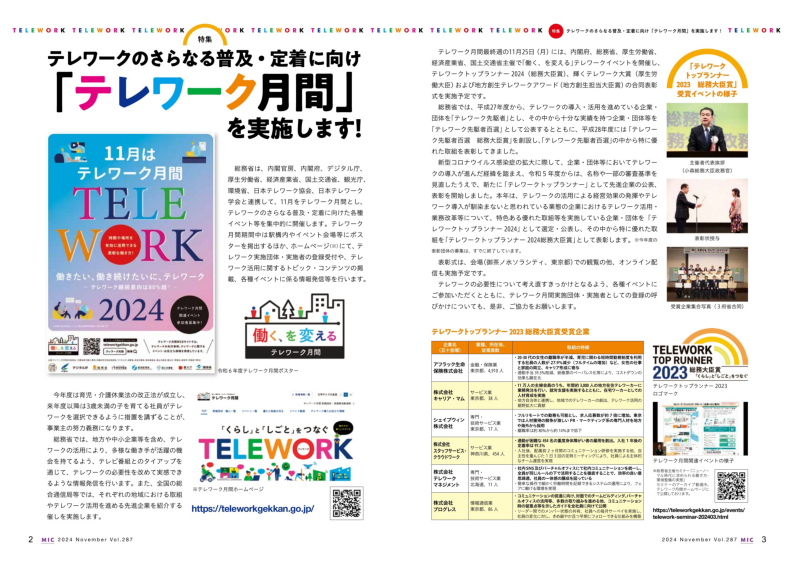

In [15]:
# サンプル画像を表示
from PIL import Image
import matplotlib.pyplot as plt
import cv2
import numpy as np

# 画像を読み込んで表示
img = Image.open(image_path)
plt.figure(figsize=(10, 8))
plt.imshow(img)
plt.axis("off")
plt.show()

### テキストの可視化

In [16]:
# エクスポート用のディレクトリを作成
import os
export_dir = "image_ocr_data"
if not os.path.exists(export_dir):
    os.makedirs(export_dir)
    print(f"📁 画像テーブルデータディレクトリを作成: {export_dir}/")
else:
    print(f"📁 既存のエクスポートディレクトリを使用: {export_dir}/")



📁 画像テーブルデータディレクトリを作成: image_ocr_data/


In [17]:
# DocumentVisualizerを使用してレイアウトの詳細を可視化
# visualize: 画像とパースされたデータを受け取り、バウンディングボックスを描画
# type='ocr': テキストを可視化
img_data.export_viz_images(folder_path=export_dir,
                    viz_type='ocr',
                    page_index=0,
                    image_path=image_path)

libraqm is not installed. Vertical text rendering is not supported. Rendering horizontally instead.


['image_ocr_data/0.png']

In [18]:
pdf_data.pages[0].export_viz_image(
    image_path=pdf_path,
    folder_path=export_dir,
    viz_type='ocr',
    page_index=0
    )

libraqm is not installed. Vertical text rendering is not supported. Rendering horizontally instead.


'image_ocr_data/0.png'

In [19]:
# PDFの場合は、ページを指定してデータを取得する
# DocumentVisualizerを使用してレイアウトの詳細を可視化
# visualize: 画像とパースされたデータを受け取り、バウンディングボックスを描画
# type='ocr': テキストを可視化
# エクスポート用のディレクトリを作成
export_dir = "pdf_ocr_data"
if not os.path.exists(export_dir):
    os.makedirs(export_dir)
    print(f"📁 画像テーブルデータディレクトリを作成: {export_dir}/")
else:
    print(f"📁 既存のエクスポートディレクトリを使用: {export_dir}/")
    
pdf_data.export_viz_images(
    image_path=pdf_path,
    folder_path=export_dir,
    viz_type='ocr')

📁 画像テーブルデータディレクトリを作成: pdf_ocr_data/


libraqm is not installed. Vertical text rendering is not supported. Rendering horizontally instead.
libraqm is not installed. Vertical text rendering is not supported. Rendering horizontally instead.
libraqm is not installed. Vertical text rendering is not supported. Rendering horizontally instead.
libraqm is not installed. Vertical text rendering is not supported. Rendering horizontally instead.
libraqm is not installed. Vertical text rendering is not supported. Rendering horizontally instead.
libraqm is not installed. Vertical text rendering is not supported. Rendering horizontally instead.
libraqm is not installed. Vertical text rendering is not supported. Rendering horizontally instead.
libraqm is not installed. Vertical text rendering is not supported. Rendering horizontally instead.
libraqm is not installed. Vertical text rendering is not supported. Rendering horizontally instead.


['pdf_ocr_data/0.png',
 'pdf_ocr_data/1.png',
 'pdf_ocr_data/2.png',
 'pdf_ocr_data/3.png',
 'pdf_ocr_data/4.png',
 'pdf_ocr_data/5.png',
 'pdf_ocr_data/6.png',
 'pdf_ocr_data/7.png',
 'pdf_ocr_data/8.png']

### レイアウトの可視化

In [ ]:
# DocumentVisualizerを使用してレイアウトの詳細を可視化
# visualize: 画像とパースされたデータを受け取り、バウンディングボックスを描画
# type='layout_detail': レイアウトの詳細（テキスト、図、表の位置）を表示
export_dir = "image_layout_data"
if not os.path.exists(export_dir):
    os.makedirs(export_dir)
    print(f"📁 画像テーブルデータディレクトリを作成: {export_dir}/")
else:
    print(f"📁 既存のエクスポートディレクトリを使用: {export_dir}/")
    
img_data.export_viz_images(
    image_path=image_path,
    folder_path=export_dir,
    viz_type='layout_detail'
    )

📁 画像テーブルデータディレクトリを作成: img_layout_data/


['img_layout_data/0.png']

In [21]:
export_dir = "pdf_layout_data"
if not os.path.exists(export_dir):
    os.makedirs(export_dir)
    print(f"📁 画像テーブルデータディレクトリを作成: {export_dir}/")
else:
    print(f"📁 既存のエクスポートディレクトリを使用: {export_dir}/")
    
pdf_data.export_viz_images(
    image_path=pdf_path,
    folder_path=export_dir,
    viz_type='layout_detail'
    )


📁 画像テーブルデータディレクトリを作成: pdf_layout_data/


['pdf_layout_data/0.png',
 'pdf_layout_data/1.png',
 'pdf_layout_data/2.png',
 'pdf_layout_data/3.png',
 'pdf_layout_data/4.png',
 'pdf_layout_data/5.png',
 'pdf_layout_data/6.png',
 'pdf_layout_data/7.png',
 'pdf_layout_data/8.png']

## テーブルデータの確認と変換
### TableExtractorを使用してテーブルデータを処理

#### 様々な形式にtableを保存できます

### 単一画像の場合

In [22]:
# エクスポート用のディレクトリを作成
import os
export_dir = "image_table_data"
if not os.path.exists(export_dir):
    os.makedirs(export_dir)
    print(f"📁 画像テーブルデータディレクトリを作成: {export_dir}/")
else:
    print(f"📁 既存のエクスポートディレクトリを使用: {export_dir}/")

# textの形式
img_data.export_tables(output_folder=export_dir,output_format='text',page_index=0)
# # htmlの形式
img_data.export_tables(output_folder=export_dir,output_format='html',page_index=0)
# # # jsonの形式
img_data.export_tables(output_folder=export_dir,output_format='json',page_index=0)
# # # csvの形式
img_data.export_tables(output_folder=export_dir,output_format='csv',page_index=0)

📁 画像テーブルデータディレクトリを作成: image_table_data/


['image_table_data/table_1.csv']

### pdfの場合

In [23]:
# エクスポート用のディレクトリを作成
import os
export_dir = "pdf_table_data"
if not os.path.exists(export_dir):
    os.makedirs(export_dir)
    print(f"📁 pdfテーブルデータディレクトリを作成: {export_dir}/")
else:
    print(f"📁 既存のエクスポートディレクトリを使用: {export_dir}/")
# textの形式
pdf_data.export_tables(output_folder=export_dir,output_format='text')
# htmlの形式
pdf_data.export_tables(output_folder=export_dir,output_format='html')
# jsonの形式
pdf_data.export_tables(output_folder=export_dir,output_format='json')
# csvの形式
pdf_data.export_tables(output_folder=export_dir,output_format='csv')

📁 pdfテーブルデータディレクトリを作成: pdf_table_data/
Found 2 tables across 9 pages
Page 2: 1 tables
Page 7: 1 tables
Found 2 tables across 9 pages
Page 2: 1 tables
Page 7: 1 tables
Found 2 tables across 9 pages
Page 2: 1 tables
Page 7: 1 tables
Found 2 tables across 9 pages
Page 2: 1 tables
Page 7: 1 tables


['pdf_table_data/table_1.csv', 'pdf_table_data/table_2.csv']